In [51]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from src.options import Options

import cv2
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from src.data.loader_factory import load_data
from src.models.encoder import EncoderCNN

In [2]:
def default_image_loader(path):

    img = Image.fromarray(
        cv2.resize(np.array(Image.open(path).convert("RGB")), (224, 224))
    )
    return img

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
sketch_fname = '../io/data/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-1.png'
sketch_fname2 = '../io/data/raw/Sketchy/sketch/tx_000000000000/airplane/n02691156_58-2.png'

im_pos_fname = '../io/data/raw/Sketchy/extended_photo/airplane/ext_1.jpg'
im_pos_fname2 = '../io/data/raw/Sketchy/extended_photo/airplane/ext_2.jpg'

In [5]:
sketch = transform(default_image_loader(sketch_fname))
sketch2 = transform(default_image_loader(sketch_fname2))
print(sketch.shape)
print(sketch2.shape)

image_pos = transform(default_image_loader(im_pos_fname))
image_pos2 = transform(default_image_loader(im_pos_fname2))
print(image_pos.shape)
print(image_pos2.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [6]:
sk_log = sketch.unsqueeze(0)
sk_log2 = sketch2.unsqueeze(0)
print(sk_log.shape)
print(sk_log2.shape)

im_log = image_pos.unsqueeze(0)
im_log2 = image_pos2.unsqueeze(0)
print(im_log.shape)
print(im_log2.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [7]:
sk_log = torch.cat((sk_log, sk_log2), dim=0)
im_log = torch.cat((im_log, im_log2), dim=0)
print(sk_log.shape)
print(im_log.shape)

torch.Size([2, 3, 224, 224])
torch.Size([2, 3, 224, 224])


In [8]:
print('Create model')
im_net = EncoderCNN(out_size=256, attention=True)
sk_net = EncoderCNN(out_size=256, attention=True)

Create model


In [11]:
_, attn_im = im_net(im_log)
print(attn_im.shape)

torch.Size([2, 1, 7, 7])


In [12]:
attn_im.view((attn_im.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

tensor([[[[0.0170]]],


        [[[0.0156]]]], grad_fn=<UnsqueezeBackward0>)

In [13]:
attn_im.view((attn_im.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

tensor([[[[0.0352]]],


        [[[0.0276]]]], grad_fn=<UnsqueezeBackward0>)

In [14]:
attn_im = nn.Upsample(size=(im_log[0].size(1), im_log[0].size(2)), mode='bilinear', align_corners=False)(attn_im)
print(attn_im.shape)
attn_im = attn_im - attn_im.view((attn_im.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
print(attn_im.shape)
attn_im = 1 - attn_im/attn_im.view((attn_im.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
print(attn_im.shape)

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


In [15]:
_, attn_sk = sk_net(sk_log)
print(attn_sk.shape)

torch.Size([2, 1, 7, 7])


In [16]:
attn_sk.view((attn_sk.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

tensor([[[[0.0168]]],


        [[[0.0159]]]], grad_fn=<UnsqueezeBackward0>)

In [17]:
attn_sk.view((attn_sk.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

tensor([[[[0.0247]]],


        [[[0.0276]]]], grad_fn=<UnsqueezeBackward0>)

In [18]:
attn_sk = nn.Upsample(size=(sk_log[0].size(1), sk_log[0].size(2)), mode='bilinear', align_corners=False)(attn_sk)
print(attn_sk.shape)
attn_sk = attn_sk - attn_sk.view((attn_sk.size(0), -1)).min(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
print(attn_sk.shape)
attn_sk = attn_sk/attn_sk.view((attn_sk.size(0), -1)).max(-1)[0].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
print(attn_sk.shape)

torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])
torch.Size([2, 1, 224, 224])


In [49]:
im_log.shape

torch.Size([2, 3, 224, 224])

In [50]:
im_log.size(0)

2

In [71]:
def transpose(tensor):
    array = tensor.detach().numpy()
    return np.transpose(array, (1,2,0))

In [38]:
for i in range(im_log.size(0)):
    # Format
    print('\nFormat')
    print(im_log[i].shape)
    print(attn_im[i].shape)
    
    # Image
    print('\nImage')
    plt_im = torch.cat([im_log[i], attn_im[i]], dim=0)
    assert isinstance(plt_im, torch.Tensor), type(plt_im)
    print(plt_im.shape)
    
    # Sketch
    print('\nSketch')
    plt_sk = sk_log[i]*attn_sk[i]
    assert isinstance(plt_sk, torch.Tensor), type(plt_sk)
    print(plt_sk.shape)
    break


Format
torch.Size([3, 224, 224])
torch.Size([1, 224, 224])

Image
torch.Size([4, 224, 224])

Sketch
torch.Size([3, 224, 224])


In [78]:
plt_im.shape

torch.Size([4, 224, 224])

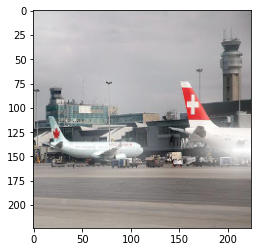

In [79]:
plt_im_t = transpose(plt_im)
plt.imshow(plt_im_t)

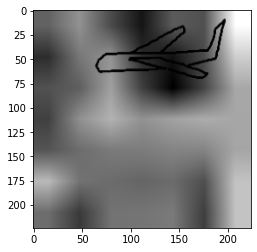

In [80]:
plt_sk_t = transpose(plt_sk)
plt.imshow(plt_sk_t)

In [72]:
im_log0 = transpose(im_log[0])
im_log1 = transpose(im_log[1])

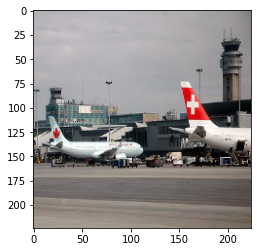

In [73]:
plt.imshow(im_log0)

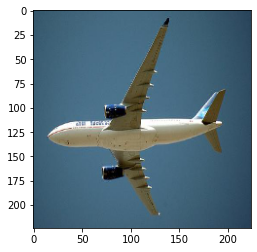

In [74]:
plt.imshow(im_log1)

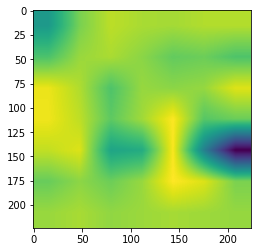

In [75]:
plt.imshow(attn_im[0].squeeze().detach().numpy())

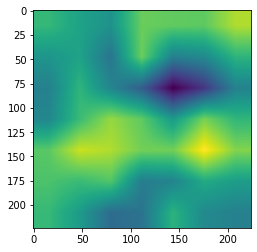

In [76]:
plt.imshow(attn_im[1].squeeze().detach().numpy())